## Problem of navie softmax model

The gradient of word vectors $\triangledown_\theta J_t(\theta) \in \Bbb{R}^{2dV}$ may be very sparse, because for each window we have at most **2m+1** words to update, but whole vocab($V$) is very a large number.

* m: window size

많은 양의 단어에 비해 업데이트 하는 파라미터수는 적기 때문에 gradient matrix 가 굉장히 sparse 해질 수 있음. Adam 같은 알고리즘은 sparse 한 matrix 에 취약함. [참고](https://simonjisu.github.io/deeplearning/2018/01/13/numpywithnn_5.html)

We may as well only update the word vectors that actually appear! 실제로 등장하는 단어만 업데이트 하자!

** Solution: **

1. only update certain columns of full embedding matrices $U$ & $V$
2. keep around a hash for word vector.

paper: Distributed representaions of Words and Phrases and their Compositionality (Mikolov et al. 2013) - [link](https://arxiv.org/abs/1310.4546)

## Negative Sampling

word2vec Explained: deriving Mikolov et al.'s negative-sampling word-embedding method - [link](https://arxiv.org/abs/1402.3722)

Main idea: train binary logistic regressions for a true pair (center word and word in its context window) versus a couple of noise pairs (the center word paired with a random word)

**Maximize Overall objective function:**

$$\begin{aligned}
J(\theta) &= \dfrac{1}{T}\sum_{t=1}^{T} J_t(\theta)\\
J(\theta) &= \log \sigma(u_o^T v_c) + \sum_{i=1}^{k} \mathbb{E}_{j \tilde{} P(w)} [\log \sigma(-u_j^T v_c)]
\end{aligned}$$

* $T$: total num of words
* $\sigma$: sigmoid function
* $P(w) = {U(w)^{3/4}} / {Z}$: unigram distribution U(w) raised to the 3/4 power
    * The pwer makes less frequent words be sampled mor often

     
So we maximize the probability of two words co-occurring in the first $\log \sigma(u_o^T v_c)$

And, sub sample a couple of the words from the corpus (j ~ P(w)), minimize their probability of co-occurring

---

### "word2vec Explained" 논문 설명(notaion 이 조금 다르니 주의):

출발점: (w, c) 세트가 정말로 corpus data로 부터 왔는가? 
* 여기서 **w = word, c = context** 다.
* 정의: 
    * $P(D = 1|\ w, c)$ : 단어 (w, c)가 corpus data로부터 왔을 확률
    * $P(D = 0|\ w, c) = 1 - P(D = 1|\ w, c)$ : 단어 (w, c)가 corpus data로부터 오지 않았을 확률
  
따라서, 우리의 목적은 확률$P(D = 1|\ w, c)$를 최대화하는 parameter $\theta$를 찾는 것이기 때문에 아래와 같은 식을 세울 수 있다.

$$\begin{aligned} &\arg \underset{\theta}{\max} \underset{(w,c) \in D}{\prod} P(D=1|\ w,c;\theta) \\
= &\arg \underset{\theta}{\max} \log \underset{(w,c) \in D}{\prod} P(D=1|\ w,c;\theta) \\
= &\arg \underset{\theta}{\max} \underset{(w,c) \in D}{\sum} \log P(D=1|\ w,c;\theta)
\end{aligned}$$ 

파라미터 $\theta$ 는 단어들의 벡터라고 생각할 수 있다. 즉, 위의 식을 만족하는 어떤 최적의 단어 벡터를 찾는것이다.

또한, 확률 $P(D=1|\ w,c;\theta)$ 은 sigmoid로 아래와 같이 정의 할 수 있다.

$$P(D=1|\ w,c;\theta) = \dfrac{1}{1+e^{-v_c v_w}}$$

따라서 우리의 목적은 아래와 같다.

$$\arg \underset{\theta}{\max} \underset{(w,c) \in D}{\sum} \log \dfrac{1}{1+e^{-v_c v_w} }$$

그러나 우리의 목적 함수는 매 (w, c)마다 $P(D=1|\ w,c;\theta)=1$ 를 만족하는 trivial solution이 존재한다. $v_c = v_w$ 이며, $\forall v_c,\ v_w$ 에 대해 $v_c \cdot v_w = K$ 를 만족하는 $\theta$ (보통 $K$ 가 40이 넘어가면 위 방정식의 값이 0에 가까워짐) 는 모든 값을 똑같이 0으로 만들어 버리기 때문에, 같은 값을 갖지 못하게 하는 매커니즘이 필요하다. ($\theta$ 에 뭘 넣어도 0이 되면 최대값을 찾는 의미가 없어짐)

하나의 방법으로 랜덤 (w, c) 조합을 생성하는 집합 $D'$를 만들어 corpus data로부터 올 확률 $P(D=1|\ w,c;\theta)$ 를 낮게 강제하는 것이다. 즉, $D'$ 에서 생성된 (w, c) 조합은 corpus data 로부터 오지 않게 하는 확률 $P(D=0|\ w,c;\theta)$ 을 최대화 하는 것.

$$\begin{aligned} 
& \arg \underset{\theta}{\max} \underset{(w,c) \in D}{\prod} P(D=1|\ w,c;\theta) \underset{(w,c) \in D'}{\prod} P(D=0|\ w,c;\theta) \\
&= \arg \underset{\theta}{\max} \underset{(w,c) \in D}{\prod} P(D=1|\ w,c;\theta) \underset{(w,c) \in D'}{\prod} \big(1- P(D=1|\ w,c;\theta) \big) \\
&= \arg \underset{\theta}{\max} \underset{(w,c) \in D}{\sum} \log P(D=1|\ w,c;\theta) + \underset{(w,c) \in D'}{\sum} \log \big(1- P(D=1|\ w,c;\theta) \big) \\
&= \arg \underset{\theta}{\max} \underset{(w,c) \in D}{\sum} \log \dfrac{1}{1+e^{-v_c v_w} } + \underset{(w,c) \in D'}{\sum} \log \big(1- \dfrac{1}{1+e^{-v_c v_w} } \big) \\
&= \arg \underset{\theta}{\max} \underset{(w,c) \in D}{\sum} \log \dfrac{1}{1+e^{-v_c v_w} } + \underset{(w,c) \in D'}{\sum} \log \dfrac{1}{1+e^{v_c v_w} }
\end{aligned}$$

Let $\sigma(x) = \dfrac{1}{1+e^{-x} }$, Then,

$$\begin{aligned} 
& \arg \underset{\theta}{\max} \underset{(w,c) \in D}{\sum} \log \dfrac{1}{1+e^{-v_c v_w} } + \underset{(w,c) \in D'}{\sum} \log \dfrac{1}{1+e^{v_c v_w} } \\
&= \arg \underset{\theta}{\max} \underset{(w,c) \in D}{\sum} \log \sigma(v_c v_w) + \underset{(w,c) \in D'}{\sum} \log \sigma(- v_c v_w)
\end{aligned}$$

This equation is similar to equation (4) in Mikolov et al (위에 링크).

$$\log \sigma(u_c^T v_w) + \sum_{i=1}^{k} \mathbb{E}_{j \tilde{} P(w)} [\log \sigma(-u_j^T v_w)]$$

다른 점이라면, 우리가 만든 식에서는 전체 corpus ($D \cup D'$) 을 포함하지만, Mikolov 논문의 식은 D 에 속하는 (w, c) 조합 하나와 k 개의 다른 (w, c_j) 의 조합을 들었다는 것이다. 구체적으로, k 번의 negative sampling 에서 Mikolov 는 $D'$ 를 $k \times D$ 보다 크게 설정했고, k개의 샘플 $(w, c_1), (w, c_2), \cdots, (w, c_k)$ 에 대해서 $c_j$ 는 **unigram distribution** 에 **3/4** 승으로 부터 도출된다. 이는 아래의 분포에서 (w, c) 조합을 추출 하는 것과 같다.

$$p_{words}(w) = \dfrac{p_{contexts} (c)^{3/4} }{Z}$$

* $p_{words}(w)$, $p_{contexts} (c)$ 는 각각 words and contexts 의 unigram distribution 이다.
* $Z$ 는 normalization constant

Mikolov 논문에서는 context는 하나의 단어이기 때문에 $p_{words}(w) = p_{contexts} (c) = \dfrac{count(x)}{ | text | }$

#### 참고
* trivial solution: 모든 해가 0 
* non-trivial solution: 무수히 많은 해가 있음(보통 하나가 free variable)
* homogenous, trival solution 개념 설명: https://www.youtube.com/watch?v=JlJWyWJARRU




---

여태까지 하려던 것: captures cooccurrence of words by one at a time

But, Why not capture cooccurrence counts directly?

**2 Options**
* window: similar to word2vec, captrues both syntactic (POS) and semantic information
* word-document co-occurrence matrix: give general topics, leading to "Latent Semantic Analysis"

## Example: Window based co-occurrence matrix

* Window length = 1 
* Symmetric (irrelevant whether left or right, can be unsymmetric but in this case yes)
* Example:
    * I like deep learning.
    * I like NLP.
    * I enjoy flying.

|counts| I | like | enjoy | deep | learning | NLP | flying | . |
|--|--|--|--|--|--|--|--|--|
| I| 0 | 2 | 1 | 0 | 0 | 0 | 0 | 0 |
|like| 2 | 0 | 0 | 1 | 0 | 1 | 0 | 0 |
|enjoy| 1 | 0 | 0 | 0 | 0 | 0 | 1 | 0 |
|deep| 0 | 1 | 0 | 0 | 1 | 0 | 0 | 0 |
|learning| 0 | 0 | 0 | 1 | 0 | 0 | 0 | 1 |
|NLP| 0 | 1 | 0 | 0 | 0 | 0 | 0 | 1 |
|flying| 0 | 0 | 1 | 0 | 0 | 0 | 0 | 1 |
|.| 0 | 0 | 0 | 0 | 1 | 1 | 1 | 0 |

In [1]:
import pandas as pd
import numpy as np
from collections import deque, Counter
from itertools import islice
from scipy.sparse import coo_matrix

sentences = ['I like deep learning .', 'I like NLP .', 'I enjoy flying .']
tokens = [s.split() for s in sentences]
vocab = list(set([w for s in tokens for w in s]))
print(vocab)

['enjoy', 'deep', 'I', 'like', 'NLP', 'learning', '.', 'flying']


In [2]:
flatten = lambda t: [tuple(j) for i in t for j in i]

def get_cooccur_list(sentence, window):
    s_len = len(sentence)
    ngram_list = [deque(islice(sentence, i), window+1) for i in range(s_len+1)][2:]
    return ngram_list

In [3]:
vocab = ['I', 'like', 'enjoy', 'deep', 'learning', 'NLP', 'flying', '.']
vocab2idx = {w: i for i, w in enumerate(vocab)}
tokens_idx = [[vocab2idx.get(w) for w in s] for s in tokens] 
window = 1
co_occurs = [get_cooccur_list(s, window) for s in tokens_idx]
d = Counter()
d.update(flatten(co_occurs))
row, col, data = list(zip(*[[r, c, v] for (r, c), v in d.items()]))
temp = coo_matrix((data, (row, col)), shape=(len(vocab), len(vocab))).toarray()
co_mat = temp.T + temp

In [4]:
pd.DataFrame(co_mat, index=vocab, columns=vocab)

,I,like,enjoy,deep,learning,NLP,flying,.
I,0,2,1,0,0,0,0,0
like,2,0,0,1,0,1,0,0
enjoy,1,0,0,0,0,0,1,0
deep,0,1,0,0,1,0,0,0
learning,0,0,0,1,0,0,0,1
NLP,0,1,0,0,0,0,0,1
flying,0,0,1,0,0,0,0,1
.,0,0,0,0,1,1,1,0


## Problems with simple co-occurrence vectors:
* Increase in size with vocabulary
* Very high dimensional: require a lot of storage
* Subsequent classification models have sparsity issues $\rightarrow$ models are less robust

## Solutions: Low dimensional vectors
Idea: store "most" of the important information in a fixed, small number of dimensions - a dense vector

How to reduce dimentionality??

### Method 1: SVD

In [5]:
U, s, Vh = np.linalg.svd(co_mat, full_matrices=False)

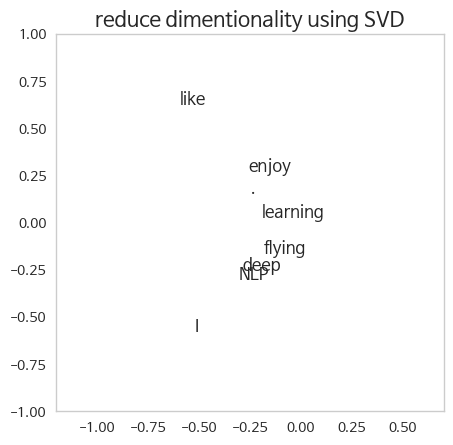

In [6]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
for i in range(len(vocab)):
    ax.annotate(vocab[i], (U[i, 0], U[i, 1]))
ax.grid(False)
ax.set_xlim(-1.2, 0.7)
ax.set_ylim(-1, 1)
ax.set_title('reduce dimentionality using SVD', fontsize=15)
plt.show()

### Hacks to X
* Problem: function words (the, he, has) are too frequent $\rightarrow$ syntax has too much impact
    * Solution: fixes count or ignore all
* Ramped windows that count closer words more
* Use Pearson correlations instead of counts, then set negative values to 0


An Improved Model of Semantic Similarity Based on Lexical Co-Occurrence Rohde et al. 2005

### Problems with SVD
Computational cost scales quadratically for n x m matrix: $O(mn^2)$ flops (when n < m) 

$\rightarrow$ Bad for millions of words or documents

## Count based vs Direct prediction

|Count based |Direct prediction|
|--|--|
|LSA, HAL (Lund & Burgess), <br> COALS, Hellinger-PCA (Rohde et al, Lebret & Collobert) | Skip-gram/CBOW (Mikolov et al) <br> NNLM, HLBL, RNN (Bengio et al; Collobert & Weston; Huang et al; Mnih & Hinton) |
|(G)Fast training <br> (G)Efficient usage of statistics <br> (B)Primarily used to capture wordsimilarity <br>  (B)Disproportionate importance given to large counts | (B)Scale with corpus size <br> (B)Inefficient usage of statistics <br> (G)Generate improved performance on other tasks <br> (G)Can capture complex patterns beyond word similarity|

# GloVe

$$J(\theta) = \dfrac{1}{2} \sum_{i,j=1}^{W} f(P_{ij})(u_i^T v_j - \log P_{ij})^2$$

Good Points(By Pennington, Socher, Manning (2014))
* Fast Training
* Scalable to huge corpora
* Good Performance even with small corpus and small vectors

Paper: [GloVe: Global Vectors for Word Representation](https://www.aclweb.org/anthology/D14-1162)

---

### Glove Paper explain

**GloVe:** Global Vectors, because the global corpus statistics are captured directly by the model

Define notation:
* $X$: matrix of word-word co-occurrence counts
* $X_{ij}$: the number of times that word $j$ occurs in the context word $i$
* $X_i = \sum_k X_{ik}$: the number of times any word appears in the context of word $i$
* $P_{ij} = P(j | i) = X_{ij} / X_i$: probability that word $j$ appear in the context word $i$


Example:
* I like deep learning.
* I like NLP.
* I enjoy flying.

In [42]:
data = (co_mat / co_mat.sum(axis=1).reshape(-1, 1))
cols = ['k='+v for v in vocab]
rows = ['p(k|{})'.format(v) for v in vocab]
P = pd.DataFrame(data, index=rows, columns=cols) + 1e-10

In [43]:
P.round(2)

,k=I,k=like,k=enjoy,k=deep,k=learning,k=NLP,k=flying,k=.
p(k|I),0.0,0.67,0.33,0.00,0.00,0.00,0.00,0.0
p(k|like),0.5,0.00,0.00,0.25,0.00,0.25,0.00,0.0
p(k|enjoy),0.5,0.00,0.00,0.00,0.00,0.00,0.50,0.0
p(k|deep),0.0,0.50,0.00,0.00,0.50,0.00,0.00,0.0
p(k|learning),0.0,0.00,0.00,0.50,0.00,0.00,0.00,0.5
p(k|NLP),0.0,0.50,0.00,0.00,0.00,0.00,0.00,0.5
p(k|flying),0.0,0.00,0.50,0.00,0.00,0.00,0.00,0.5
p(k|.),0.0,0.00,0.00,0.00,0.33,0.33,0.33,0.0


$i$ = deep, $j$ = NLP. When $k$ = learning, we expect $P_{ik}/P_{jk}$ be very lagre, vice versa. When $k$ = like, expect $P_{ik}/P_{jk}$ should be close to one.

In [55]:
# P_ij, i=deep / j=NLP
P.loc['p(k|deep)','k=learning'] / P.loc['p(k|NLP)','k=learning']

5000000001.0

In [58]:
# P_ij, i=NLP / j=deep
P.loc['p(k|NLP)','k=learning'] / P.loc['p(k|deep)','k=learning']

1.9999999996e-10

In [57]:
# P_ij, i=learning / j=NLP
P.loc['p(k|deep)','k=like'] / P.loc['p(k|NLP)','k=like']

1.0

The above argument suggests that the appropriate starting point for word vector learning should be with ratios of co-occurrence probabilities rather than the probabilities themselves.

Noting that the ratio $P_{ik} /P_{jk}$ depends on three words $i$, $j$, and $k$, the most general model takes the form,

$$F(w_i, w_j, \tilde{w}_k) = \dfrac{P_{ik} }{P_{jk} } \cdots (1)$$

* $w \in \Bbb{R}^d$: word vectors
* $\tilde{w} \in \Bbb{R}^d$: separate context word vectors

Expect finding a linear structure function $F$ where inputs are $w_i, w_j, \tilde{w}_k$ to encode the information present the ratio $\dfrac{P_{ik} }{P_{jk} }$ in the word vector space.

Let $F$ be $F((w_i - w_j)^T \tilde{w}_k) = \dfrac{P_{ik} }{P_{jk} } \cdots (2)$, so that both side of equation can be a scalar value. Also, can try to capture the linear relation between $w_i, w_j$ and $\tilde{w}_k$

Next, note that for word-word co-occurrence matrices, the distinction between a word and a context word is arbitrary and that we are free to exchange the two roles. To do so consistently, we must not only exchange $w \leftrightarrow \tilde{w}$, but also $X \leftrightarrow X^T$. + $F(X-Y) = F(X) / F(Y)$

Final model must contains these.

Symmetry:

First, F be a **homomorphism** between groups $(\Bbb{R}, +)$ and $(\Bbb{R}_{>0}, \times)$,

$$F(w_i, w_j, \tilde{w}_k) = \dfrac{F(w_i^T \tilde{w}_k) }{F(w_j^T \tilde{w}_k) } \cdots (3)$$
    
by equation $(2)$ is solved by, 

$$F(w_i^T \tilde{w}_k) = P_{ik} = \dfrac{X_{ik} }{X_i} \cdots (4)$$

The solution for equation $(4)$ is $F = \exp$, so,

$$w_i^T \tilde{w}_k = \log(P_{ik}) = \log(X_{ik}) - \log(X_i) \cdots (5)$$

Next, $(5)$ will be symmetric if not $\log(X_i)$. Let's see is $\log(P_{ik})=\log(P_{ki})$

$$\begin{aligned} 
\log(P_{ik}) &= \log(X_{ik}) - \log(X_i) \\
\log(P_{ki}) &= \log(X_{ki}) - \log(X_k)
\end{aligned}$$

Obiously, term $\log(X_i) \neq \log(X_k)$ makes $\log(P_{ik}) \neq \log(P_{ki})$

However $\log(X_i)$ term is independent of $k$ so it can be absorbed into a bias $b_i$ for $w_i$.

Finally adding an additional bias $\tilde{b}_k$ for $\tilde{w}_k$ restores the symmetry.

$$w_i^T \tilde{w}_k + b_i + \tilde{b}_k = \log(X_{ik}) \cdots (6)$$